In [1]:
import gpflow
import numpy as np
import pandas as pd
import tensorflow as tf
from gpflow.base import _cast_to_dtype
from models.test_functions import TestFunUncorrelated
from gpflow.utilities import to_default_float, print_summary
from gpflow.config import default_float
# from gpflow.ci_utils import ci_niter
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from utils.utils import build_models, \
    train_models, get_final_models_dict, get_gridpoints, get_nlpd, get_abs_error
from models.lvmogp import LVMOGP

2023-10-02 16:05:56.099206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# LVMOGP with Different Prediction Method

This notebook demonstrates the difference of behaviours of the two prediction methods.

Predict method 1 - only using the mean of the latent variables (so treating as a point estimate)

Predict method 2 - taking the expectation over the latent variable locations i.e. q(H)


- [Create the Test Function](#part1)
- [Set Hyperparameters for LVMOGPs](#part5)
- [Create LVMOGP and Predict using Method 1](#part2)
- [Create LVMOGP and Predict using Method 2](#part3)
- [Create LVMOGP and Predict using Method 2 with no latent variance](#part4)



[Back to top](#Index:)

<a id='part1'></a>

## Create the Test Functions

Here we use the TestFun class to create a test function with the dimensions, latent dims, number of functions and noise
that we want.


In [2]:
seed = 2
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
model_names = ['lvmogp']
same_points = False
plot_figs = True
opt_seed = np.random.randint(0, 100)
domain = [0, 2]
latent_dims = 2
observed_dims = 1
max_points = 20
noise = 0.05
n_grid_points = 100
continuous_dims = ['x1', 'x2'][:observed_dims]
lengthscales_x = [0.3, 0.3]
n_new_points = 2
n_new_funs = 10
n_fun = 2 + n_new_funs
total_train = 10 * 2 + 3 * n_new_points  # total number of training points
n_points = [12, 20, 8 , 3, 5, 10, 3, 4, 5, 2, 14, 20, 28, 32]# number of points on each surface

test_fun = TestFunUncorrelated(domain, seed, n_fun, observed_dims, latent_dims=2, max_points=100, noise=0.1,
                 n_grid_points=100, same_points=False, lengthscales_X=lengthscales_x)

data_X, fun_nos, data_y = test_fun.create_data(n_points=n_points)

2023-10-02 16:06:02.716645: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


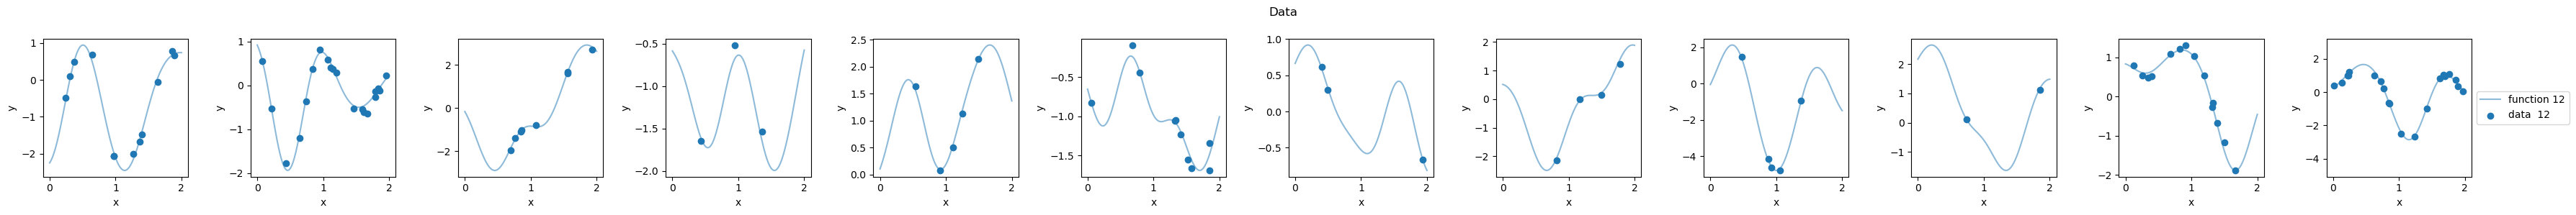

In [4]:
if plot_figs:
    test_fun.plot_data_seperate_plots() #n_points=n_points

## Fit the LVMOGP

We do different initialisations for the LVMOGP, train them all and select the model with the best ELBO.

In [10]:
models_dict = build_models(model_names, data_X, data_y, fun_nos, n_fun, observed_dims, latent_dims, 2,
                           domain, n_restarts=1)

successful build model lvmogp, restart 0, init_type random
successful build model lvmogp, restart 0, init_type mo_pca
successful build model lvmogp, restart 0, init_type gpy


In [11]:
models_dict, lmls = train_models(models_dict)

successful train lvmogp, restart 0, init_type random
successful train lvmogp, restart 0, init_type mo_pca
successful train lvmogp, restart 0, init_type gpy


In [12]:
final_models_dict = get_final_models_dict(models_dict)

In [13]:
lvmogp = final_models_dict['lvmogp']


In [ ]:
from utils.plotting_utils import plot_lvmogp_latent_variables

plot_lvmogp_latent_variables(lvmogp)

[Back to top](#Index:)

<a id='part2'></a>

## Predict On Grid Using Predict Method 1


In [ ]:
x_new, fun_nos_new, _, x_new_lvmogp = get_gridpoints(domain, n_fun, final_models_dict, observed_dims, n_points=100)

In [ ]:
pred_mu_1, pred_var_1 = lvmogp.predict_f_point_predictions(x_new_lvmogp[0])
pred_var_1 = pred_var_1 + tf.linalg.diag([lvmogp.likelihood.variance.numpy()]*len(tf.linalg.diag_part(pred_var_1) ))

[Back to top](#Index:)

<a id='part3'></a>

## Predict On Grid Using Predict Method 2

In [ ]:
pred_mu_2, pred_var_2 = lvmogp.predict_y(x_new_lvmogp)

[Back to top](#Index:)

<a id='part4'></a>

## Compare Predict Methods

Plot the predictions

In [ ]:
ys_new = []
for fun in test_fun.functions:
    y_new, _ = fun.predict_y(x_new.reshape(100, 1))
    ys_new.append(y_new)

predict_dict = {'method 1': [pred_mu_1, pred_var_1], 'method 2': [pred_mu_2, pred_var_2]}

for method_name, predictions in predict_dict.items():
    pred_mu, pred_var = predictions
    fig, axs = plt.subplots(nrows=1, ncols=n_fun, figsize=(20, 3))
    for i, fun_no in enumerate(range(n_fun)):
        idx = np.where([fun_nos_new == fun_no])[1]
        axs[i].plot(x_new, pred_mu.numpy()[idx].flatten())
        axs[i].fill_between(x_new.flatten(),
                            pred_mu.numpy()[idx].flatten() + np.sqrt(pred_var.numpy()[idx].flatten()),
                            pred_mu.numpy()[idx].flatten() - np.sqrt(pred_var.numpy()[idx].flatten()), alpha=0.2)
        axs[i].plot(x_new, ys_new[i].numpy(), linestyle=':')
        idx_train = np.where([test_fun.fun_no == fun_no])[1]
        axs[i].scatter(test_fun.X[idx_train], test_fun.y[idx_train])
        axs[i].set_ylim(np.min(data_y) - 0.6, np.max(data_y) + 0.6)
        axs[i].set_title(method_name)

Plot them on top of each other:

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=n_fun, figsize=(20, 3))
for method_name, predictions in predict_dict.items():
    pred_mu, pred_var = predictions
    for i, fun_no in enumerate(range(n_fun)):
        idx = range(n_grid_points * i, n_grid_points * (i + 1))
        axs[i].plot(x_new, pred_mu.numpy()[idx].flatten())
        axs[i].fill_between(x_new.flatten(),
                            pred_mu.numpy()[idx].flatten() + np.sqrt(pred_var.numpy()[idx].flatten()),
                            pred_mu.numpy()[idx].flatten() - np.sqrt(pred_var.numpy()[idx].flatten()), alpha=0.2)
        axs[i].plot(x_new, ys_new[i].numpy(), linestyle=':')
        idx_train = np.where([test_fun.fun_no == fun_no])[1]
        axs[i].scatter(test_fun.X[idx_train], test_fun.y[idx_train])
        axs[i].set_ylim(np.min(data_y) - 0.6, np.max(data_y) + 0.6)
        axs[i].set_title(method_name)



Calculate the root mean squared error (RMSE) and negative log predictive density (NLPD)

In [ ]:
res_dfs = []
for method_name, predictions in predict_dict.items():
    NLPDs = []
    RMSEs = []
    NLPDs_new_only = []
    RMSEs_new_only = []
    pred_mu, pred_var = predictions
    for i, fun_no in enumerate(range(n_fun)):
        idx = range(n_grid_points * i, n_grid_points * (i + 1))
        mu = pred_mu.numpy()[idx].flatten()
        sig2 = pred_var.numpy()[idx].flatten()
        nlpds = get_nlpd(mu, sig2, ys_new[i].numpy().flatten())
        abs_errors = get_abs_error(mu, ys_new[i].numpy().flatten())
        NLPDs.append(nlpds)
        RMSEs.append(abs_errors)
        if fun_no >= (n_fun - n_new_funs):
            # print(fun_no)
            NLPDs_new_only.append(nlpds)
            RMSEs_new_only.append(abs_errors)
    nlpd = np.mean(NLPDs)
    rmse = np.sqrt(np.mean(np.square(RMSEs)))
    nlpd_new_only = np.mean(NLPDs_new_only)
    rmse_new_only = np.sqrt(np.mean(np.square(RMSEs_new_only)))
    row_df = pd.DataFrame(data=[[method_name, nlpd, rmse, nlpd_new_only, rmse_new_only]],
                          columns=['model', 'nlpd', 'rmse', 'nlpd_new_surface', 'rmse_new_surface'])
    res_dfs.append(row_df)
results_df = pd.concat(res_dfs)
print(results_df)